In [26]:
import re
from collections import Counter
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Daten vorbereiten

In [27]:
sentences_file_path = "deu_news_2024_10K-sentences.txt"

ARTIKEL = {"der", "die", "das", "ein", "eine"}
PRÄPOSITIONEN = {"in", "auf", "unter", "mit", "vor"}
KONJUNKTIONEN = {"aber", "und", "oder", "dass"}
SATZZEICHEN = {",", ".", ":", "?"} 

def tokenize(sentence):
    sentence = re.sub(r'["“”»«]', '', sentence)
    tokens = re.findall(r'\w+|[^\w\s]', sentence)
    return [token if token in SATZZEICHEN or token.isalnum() else "" for token in tokens]


def get_word_class(word, is_first_in_sentence=False):
    if word in ARTIKEL:
        return "Artikel"
    elif word in PRÄPOSITIONEN:
        return "Präposition"
    elif word in KONJUNKTIONEN:
        return "Konjunktion"
    elif word in SATZZEICHEN:
        return "Satzzeichen"
    elif word[0].isupper() and not is_first_in_sentence:
        return "Nomen"
    elif word.endswith("en") and not word[0].isupper():
        return "Verb"
    else:
        return "Adjektiv"  # Fallback-Kategorie


with open(sentences_file_path, 'r', encoding='utf-8') as f:
    raw_sentences = [line.strip().split('\t')[1] for line in f]

all_words = []
cleaned_sentences = []
for sentence in raw_sentences:
    tokens = tokenize(sentence)
    tokens = [token for token in tokens if token]
    if tokens:  
        cleaned_sentences.append(" ".join(tokens))
        all_words.extend(tokens)

word_counts = Counter(all_words)

grundvokabular = [word for word, count in word_counts.most_common(8000)]
grundvokabular_set = set(grundvokabular)

word_to_class = {}
for word in grundvokabular:
    if word[0].isupper():
        word_to_class[word] = "Nomen"
    else:
        word_to_class[word] = get_word_class(word)

filtered_sentences = []
for sentence in cleaned_sentences:
    tokens = tokenize(sentence)
    if all(token in grundvokabular_set for token in tokens):
        filtered_sentences.append(sentence)

word_to_idx = {word: idx for idx, word in enumerate(grundvokabular)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
unique_classes = list(set(word_to_class.values()))
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"Ursprüngliche Anzahl der Sätze: {len(raw_sentences)}\nAnzahl der behaltenen Sätze nach Filterung: {len(filtered_sentences)}\nAnzahl der Wörter im Grundvokabular: {len(grundvokabular)}\n\nDie ersten 5 Wörter des Grundvokabulars (zur Überprüfung):")
for i, word in enumerate(grundvokabular[:5], 1):
    print(f"{i}. {word} ({word_to_class[word]})")
print("\nDie ersten 5 gefilterten Sätze (zur Überprüfung):")
for i, sentence in enumerate(filtered_sentences[:5], 1):
    print(f"{i}. {sentence}")

Ursprüngliche Anzahl der Sätze: 10000
Anzahl der behaltenen Sätze nach Filterung: 1202
Anzahl der Wörter im Grundvokabular: 8000

Die ersten 5 Wörter des Grundvokabulars (zur Überprüfung):
1. . (Satzzeichen)
2. , (Satzzeichen)
3. der (Artikel)
4. die (Artikel)
5. und (Konjunktion)

Die ersten 5 gefilterten Sätze (zur Überprüfung):
1. Ab 1 . September dürfen vier Besucherinnen beziehungsweise Besucher gleichzeitig empfangen werden .
2. Aber auch davon nahm sie sich im Februar 2024 eine Auszeit .
3. Aber auch für einen elektrischen Grill würde die Leistung reichen .
4. Aber auch unter einer Harris würden für die Europäer die Bäume nicht in den Himmel wachsen .
5. Aber Brücken sollen verbinden


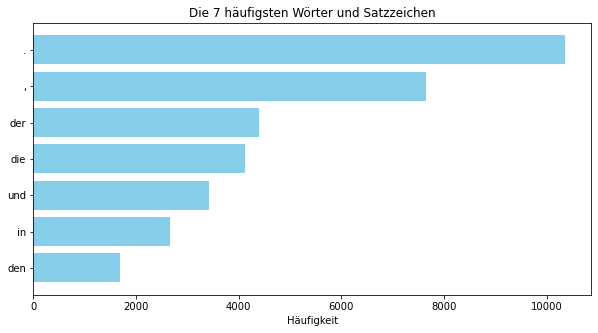

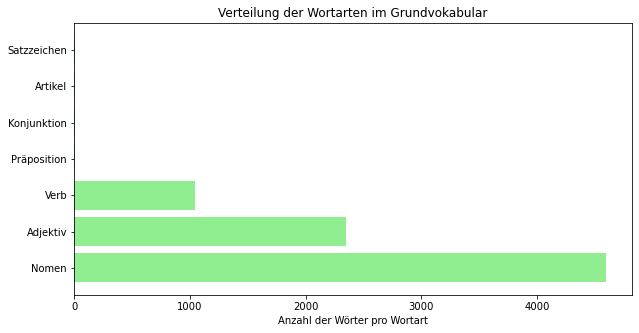

In [28]:
top_7_words = word_counts.most_common(7) 
words, counts = zip(*top_7_words)

plt.figure(figsize=(10, 5))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Häufigkeit')
plt.title('Die 7 häufigsten Wörter und Satzzeichen')
plt.gca().invert_yaxis()
plt.show()

class_counts = Counter(word_to_class.values())

classes, class_freqs = zip(*class_counts.items())

plt.figure(figsize=(10, 5))
plt.barh(classes, class_freqs, color='lightgreen')
plt.xlabel('Anzahl der Wörter pro Wortart')
plt.title('Verteilung der Wortarten im Grundvokabular')
plt.gca().invert_yaxis()
plt.show()

In [44]:
common_200 = set([word for word, count in word_counts.most_common(200)])
common_850 = set([word for word, count in word_counts.most_common(850)])

# Trainingsmenge anpassen um Grundvokab. darin zu erhöhen
train_sentences = []
for sentence in filtered_sentences:
    tokens = tokenize(sentence)
    if all(token in common_200 for token in tokens):
        train_sentences.extend([sentence] * 200)
    elif all(token in common_850 for token in tokens):
        train_sentences.extend([sentence] * 20)
    else:
        train_sentences.append(sentence)

random.shuffle(train_sentences)        

print("Anzahl der Sätze in der angepassten Trainingsmenge:", len(train_sentences))
print("vorher", len(filtered_sentences))

Anzahl der Sätze in der angepassten Trainingsmenge: 2256
vorher 1202


# Modell und Training

In [45]:
class SmallLanguageModel(nn.Module):
    def __init__(self, vocab_size, class_size, embedding_dim, hidden_dim):
        super(SmallLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc_word = nn.Linear(hidden_dim, vocab_size)
        self.fc_class = nn.Linear(hidden_dim, class_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        word_output = self.fc_word(output)
        class_output = self.fc_class(output)
        return word_output, class_output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, hidden_dim)

    
vocab_size = len(grundvokabular)
class_size = len(unique_classes)
embedding_dim = 25
hidden_dim = 100
model = SmallLanguageModel(vocab_size, class_size, embedding_dim, hidden_dim)

In [46]:
def prepare_data(sentence):
    tokens = tokenize(sentence)
    if len(tokens) < 2:
        return None, None, None
    cut_point = random.randint(1, len(tokens) - 1)
    inputs = [word_to_idx.get(token, 0) for token in tokens[:cut_point]]
    targets_word = [word_to_idx.get(tokens[cut_point], 0)]
    targets_class = [class_to_idx[word_to_class.get(tokens[cut_point], "Adjektiv")]]
    return (torch.tensor(inputs), torch.tensor(targets_word), torch.tensor(targets_class))


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion_word = nn.CrossEntropyLoss()
criterion_class = nn.CrossEntropyLoss()
word_loss_weight = 0.4
class_loss_weight = 0.6

loss_history = []
wl_history = []
cl_history = []
epoch_history = []


# Training
for epoch in range(12):
    print(f"\nStarte Epoche {epoch+1}")
    total_loss = 0
    total_word = 0
    total_class = 0
    
    sentence_count = 0
    
    for sentence in train_sentences:
        sentence_count += 1
        inputs, targets_word, targets_class = prepare_data(sentence)
        if inputs is None or len(inputs) == 0:
            continue
        hidden = model.init_hidden(1)
        optimizer.zero_grad()
        word_output, class_output, hidden = model(inputs.unsqueeze(0), hidden)

        word_output_last = word_output[:, -1, :]
        class_output_last = class_output[:, -1, :]
        
        # Loss berechnen
        loss_word = criterion_word(word_output_last, targets_word)
        loss_class = criterion_class(class_output_last, targets_class)
        loss = word_loss_weight * loss_word + class_loss_weight * loss_class
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_word += loss_word.item()
        total_class += loss_class.item()
        
        if sentence_count % 200 == 0:
            loss_history.append(loss.item())
            print(f"  Satz {sentence_count}: Loss = {loss.item():.4f}, Wort-Loss = {loss_word.item():.4f}, Wortart-Loss = {loss_class.item():.4f}")
    
    avg_word = total_word / sentence_count if sentence_count > 0 else 0
    avg_class = total_class / sentence_count if sentence_count > 0 else 0
    avg_loss = total_loss / sentence_count if sentence_count > 0 else 0
    epoch_history.append(avg_loss)
    wl_history.append(avg_word)
    cl_history.append(avg_class)
    print(f"Epoche {epoch+1} abgeschlossen. Durchschnittlicher Loss: {avg_loss:.4f}")


Starte Epoche 1
  Satz 200: Loss = 2.3067, Wort-Loss = 5.1947, Wortart-Loss = 0.3813
  Satz 400: Loss = 2.4912, Wort-Loss = 5.7169, Wortart-Loss = 0.3408
  Satz 600: Loss = 6.7865, Wort-Loss = 13.4615, Wortart-Loss = 2.3366
  Satz 800: Loss = 2.6920, Wort-Loss = 6.1075, Wortart-Loss = 0.4150
  Satz 1000: Loss = 5.6429, Wort-Loss = 11.9010, Wortart-Loss = 1.4708
  Satz 1200: Loss = 2.3186, Wort-Loss = 5.1053, Wortart-Loss = 0.4608
  Satz 1400: Loss = 1.9244, Wort-Loss = 4.0123, Wortart-Loss = 0.5325
  Satz 1600: Loss = 4.8565, Wort-Loss = 10.3595, Wortart-Loss = 1.1879
  Satz 1800: Loss = 3.8374, Wort-Loss = 3.8991, Wortart-Loss = 3.7962
  Satz 2000: Loss = 0.0517, Wort-Loss = 0.0321, Wortart-Loss = 0.0647
  Satz 2200: Loss = 3.8751, Wort-Loss = 7.6677, Wortart-Loss = 1.3466
Epoche 1 abgeschlossen. Durchschnittlicher Loss: 3.8078

Starte Epoche 2
  Satz 200: Loss = 1.7397, Wort-Loss = 3.0175, Wortart-Loss = 0.8878
  Satz 400: Loss = 6.2959, Wort-Loss = 10.6175, Wortart-Loss = 3.4149
  

  Satz 2000: Loss = 0.0037, Wort-Loss = 0.0037, Wortart-Loss = 0.0036
  Satz 2200: Loss = 4.8375, Wort-Loss = 5.3764, Wortart-Loss = 4.4782
Epoche 10 abgeschlossen. Durchschnittlicher Loss: 3.0195

Starte Epoche 11
  Satz 200: Loss = 2.2039, Wort-Loss = 4.4126, Wortart-Loss = 0.7315
  Satz 400: Loss = 1.6959, Wort-Loss = 2.7303, Wortart-Loss = 1.0063
  Satz 600: Loss = 0.5337, Wort-Loss = 0.0247, Wortart-Loss = 0.8731
  Satz 800: Loss = 5.3710, Wort-Loss = 7.1167, Wortart-Loss = 4.2071
  Satz 1000: Loss = 8.2123, Wort-Loss = 18.4055, Wortart-Loss = 1.4168
  Satz 1200: Loss = 4.6744, Wort-Loss = 5.3888, Wortart-Loss = 4.1982
  Satz 1400: Loss = 0.0295, Wort-Loss = 0.0180, Wortart-Loss = 0.0371
  Satz 1600: Loss = 8.7969, Wort-Loss = 14.5185, Wortart-Loss = 4.9825
  Satz 1800: Loss = 6.7657, Wort-Loss = 16.6065, Wortart-Loss = 0.2052
  Satz 2000: Loss = 0.0102, Wort-Loss = 0.0022, Wortart-Loss = 0.0155
  Satz 2200: Loss = 8.5152, Wort-Loss = 21.2519, Wortart-Loss = 0.0241
Epoche 11 abges

In [9]:
# Modell speichern
torch.save(model.state_dict(), "language_model.pth")
print("Modellparameter wurden in 'language_model.pth' gespeichert.")

Modellparameter wurden in 'language_model.pth' gespeichert.


# Testen

In [10]:
def generate_sentence(model, start_sentence, max_length=20):
    model.eval()
    tokens = tokenize(start_sentence)
    input_ids = [word_to_idx.get(token, 0) for token in tokens]
    if any(id == 0 for id in input_ids if tokens[input_ids.index(id)] not in grundvokabular_set):
        print("Warnung: Einige Wörter im Start-Satz sind nicht im Vokabular.")
        return None
    
    input_tensor = torch.tensor(input_ids).unsqueeze(0)
    hidden = model.init_hidden(1)
    output_words = tokens.copy()
    word_classes = [word_to_class.get(token, "Adjektiv") for token in tokens]

    sentence_enders = {'.', '?', '!'} # Satzendende-Zeichen definieren
    
    for _ in range(max_length - len(tokens)):
        word_output, class_output, hidden = model(input_tensor, hidden)
        
        next_word_idx = torch.argmax(word_output[:, -1, :], dim=1).item()
        next_word = idx_to_word[next_word_idx]
        next_class_idx = torch.argmax(class_output[:, -1, :], dim=1).item()
        next_class = idx_to_class[next_class_idx]
        
        output_words.append(next_word)
        word_classes.append(next_class)
        
        if next_word in sentence_enders:
            break
        
        input_tensor = torch.tensor([[next_word_idx]])

    sentence = ""
    for i, (word, predicted_class) in enumerate(zip(output_words, word_classes)):
        actual_class = word_to_class.get(word, predicted_class)
        if i == 0:
            formatted_word = word.capitalize()
        elif actual_class == "Nomen":
            formatted_word = word.capitalize()
        else:
            formatted_word = word.lower()
        
        if formatted_word in [',', '.', '!', '?', ';', ':']:
            sentence += formatted_word
        else:
            sentence += " " + formatted_word if i > 0 else formatted_word

        if formatted_word in sentence_enders:
            break
    
    return sentence.strip()

In [149]:
start_sentence = "Die Wirtschaft ist dieses Jahr"
generated = generate_sentence(model, start_sentence)
if generated:
    print("\nGenerierter Satz:", generated)
else:
    print("Konnte keinen Satz generieren, da unbekannte Wörter im Start-Satz.")


Generierter Satz: Die Wirtschaft ist dieses Jahr sicher.


In [156]:
sentence2 = "Die Bahn kommt"
generated = generate_sentence(model, sentence2)
print(generated)

Die Bahn kommt also?


# Visualisierung

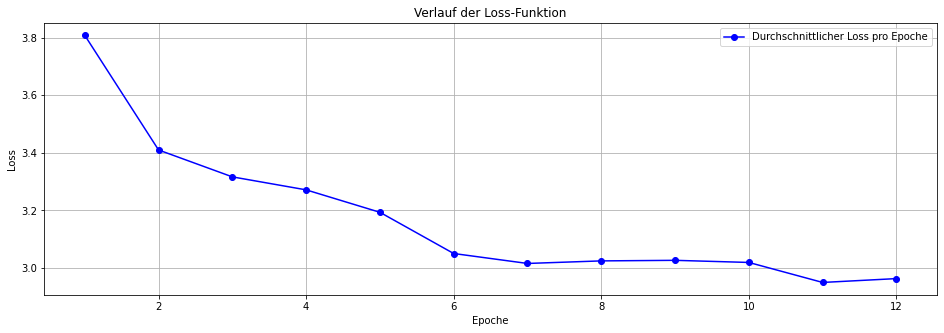

In [47]:
plt.figure(figsize=(16, 5))
plt.plot(range(1, len(epoch_history) + 1), epoch_history, marker='o', linestyle='-', color='b', label='Durchschnittlicher Loss pro Epoche')
plt.title('Verlauf der Loss-Funktion')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

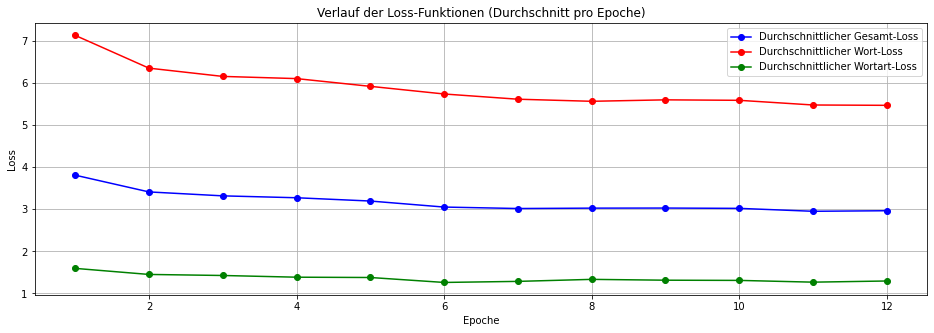

In [49]:
plt.figure(figsize=(16, 5))
plt.plot(range(1, len(epoch_history) + 1), epoch_history, 
         marker='o', linestyle='-', color='b', label='Durchschnittlicher Gesamt-Loss')
plt.plot(range(1, len(wl_history) + 1), wl_history, 
         marker='o', linestyle='-', color='r', label='Durchschnittlicher Wort-Loss')
plt.plot(range(1, len(cl_history) + 1), cl_history, 
         marker='o', linestyle='-', color='g', label='Durchschnittlicher Wortart-Loss')

plt.title('Verlauf der Loss-Funktionen (Durchschnitt pro Epoche)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

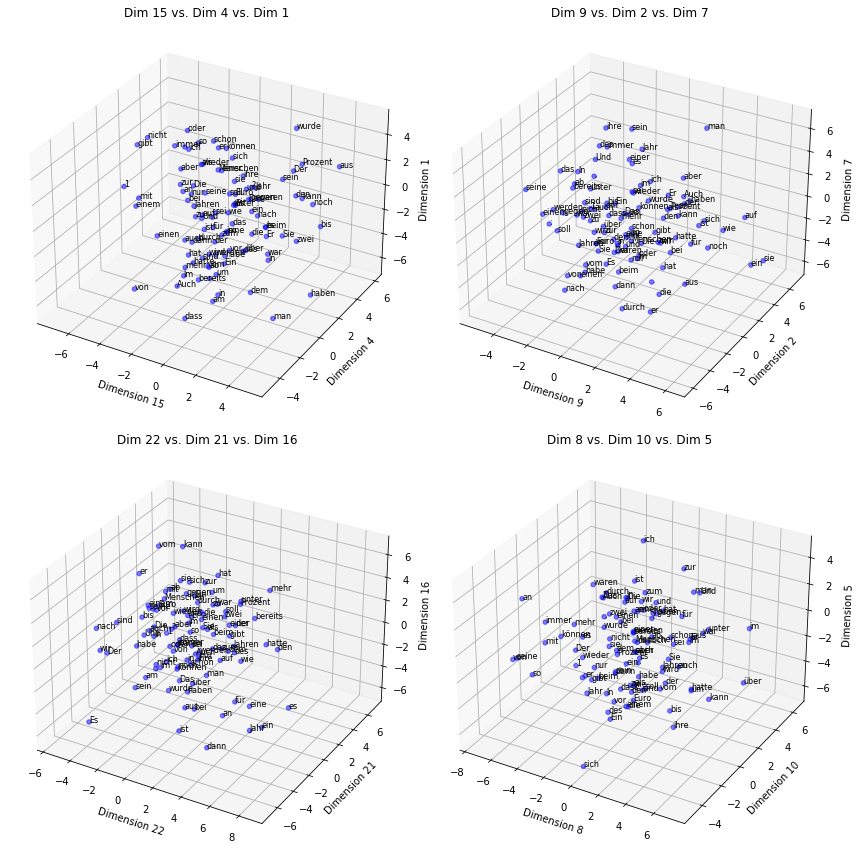

In [13]:
# Semantischer Vektorraum
n_words = 100
embedding_weights = model.embedding.weight.detach().cpu().numpy()
embedding_weights = embedding_weights[:n_words]
embedding_dim = embedding_weights.shape[1]
np.random.seed(63)
selected_dims = np.random.choice(embedding_dim, size=(4, 3), replace=False)

fig = plt.figure(figsize=(12, 12))

for i, (dim1, dim2, dim3) in enumerate(selected_dims):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(embedding_weights[:, dim1], 
               embedding_weights[:, dim2], 
               embedding_weights[:, dim3], 
               c='blue', alpha=0.5)
    
    sample_indices = list(range(n_words))
    for idx in sample_indices:
        ax.text(embedding_weights[idx, dim1], 
                embedding_weights[idx, dim2], 
                embedding_weights[idx, dim3], 
                grundvokabular[idx], 
                fontsize=8)
    
    ax.set_title(f'Dim {dim1} vs. Dim {dim2} vs. Dim {dim3}')
    ax.set_xlabel(f'Dimension {dim1}')
    ax.set_ylabel(f'Dimension {dim2}')
    ax.set_zlabel(f'Dimension {dim3}')
    ax.grid(True)

plt.tight_layout()
plt.show()